# Exercise 06 : Scatter Matrix

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

In [2]:
conn = sqlite3.connect('../data/checking-logs.sqlite')

In [3]:
# Create test and control tables
conn.execute("DROP TABLE IF EXISTS datamart")
conn.execute("DROP TABLE IF EXISTS test")
conn.execute("DROP TABLE IF EXISTS control")

datamart_query = """
CREATE TABLE datamart AS
SELECT c.uid, c.labname, MIN(c.timestamp) AS first_commit_ts, MIN(p.datetime) AS first_view_ts
FROM checker c
LEFT JOIN pageviews p ON c.uid = p.uid
WHERE c.status = 'ready' AND c.numTrials = 1 AND c.labname IN ('laba04', 'laba04s', 'laba05', 'laba06', 'laba06s', 'project1')
AND c.uid LIKE 'user_%'
GROUP BY c.uid, c.labname;
"""
conn.execute(datamart_query)
datamart_df = pd.io.sql.read_sql("SELECT * FROM datamart", conn)
datamart_df['first_commit_ts'] = pd.to_datetime(datamart_df['first_commit_ts'])
datamart_df['first_view_ts'] = pd.to_datetime(datamart_df['first_view_ts'])
test = datamart_df[datamart_df['first_view_ts'].notnull()]
control = datamart_df[datamart_df['first_view_ts'].isnull()]
control_avg = test['first_view_ts'].mean()
control.loc[:, 'first_view_ts'] = control['first_view_ts'].fillna(control_avg)
test.to_sql('test', conn, index=False)
control.to_sql('control', conn, index=False)

81

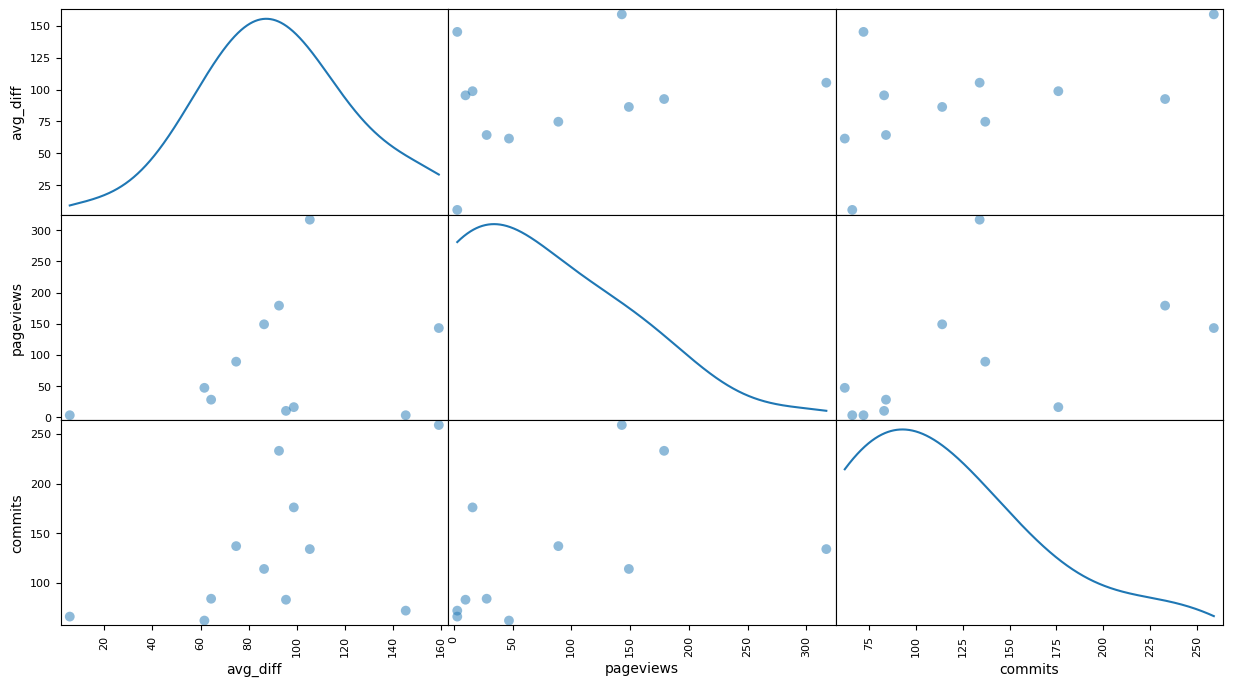

In [4]:
query = """
SELECT test.uid, AVG((deadlines.deadlines - strftime('%s', first_commit_ts)) / 3600) AS avg_diff, COUNT(DISTINCT datetime) AS pageviews
FROM test
JOIN deadlines ON test.labname = deadlines.labs
JOIN pageviews ON test.uid = pageviews.uid
WHERE test.labname != 'project1'
GROUP BY test.uid;
"""

df = pd.read_sql(query, conn)

checker_query = """
SELECT uid, COUNT(DISTINCT timestamp) AS commits
FROM checker
WHERE uid IN (SELECT DISTINCT uid FROM test WHERE labname != 'project1')
GROUP BY uid;
"""

checker_df = pd.read_sql(checker_query, conn)

df = df.merge(checker_df, on='uid', how='left').fillna(0)

scatter_matrix(df[['avg_diff', 'pageviews', 'commits']], figsize=(15, 8), diagonal='kde', s=200)
plt.show()

In [5]:
conn.close()

#### Can we say that if a user has a low number of pageviews then they likely have a low number of commits?
    Yes

#### Can we say that if a user has a low number of pageviews then they likely have a small average difference between the first commit and the lab deadline?
    No

#### Can we say that there are many users with a low number of commits and a few with a high number of commits?
    Yes

#### Can we say that there are many users with a small average difference and a few with a large average difference?
    No